In [1]:
import os, glob, pickle
import numpy as np
from utils.training import train_cplmixVAE
from utils.eval_models import eval_mixmodel
from utils.cluster_analysis import K_selection
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

In [2]:
n_run = 1
n_categories = 10
state_dim = 10
n_arm = 2
tau = .1
fc_dim = 100
latent_dim = 30
lr = 0.001
p_drop = .2
batch_size = 1000
n_epoch = 1000
n_epoch_p = 1000
n_gene = 4130
subclass = 'L4-IT'
device = None

In [3]:
# AD_MTG_norm_L4-IT_ngene_7787.p
# AD_MTG_L4-IT_ngene_4130.p
data_path = '/MTG_AD_data/all_donors_data/AD_MTG_L4-IT_nGene_' + str(n_gene) + '_nDonor_84.p'
path = os.getcwd()
folder_name = f'{subclass}_run_{n_run}_K_{n_categories}_Sdim_{state_dim}_ngene_{n_gene}_fcDim_{fc_dim}_latDim_{latent_dim}_lr_{lr}_pDrop_{p_drop}_n_arm_{n_arm}_tau_{tau}_bsize_{batch_size}_nepoch_{n_epoch}_nepochP_{n_epoch_p}'
saving_folder = path + "/results/cpl_mixVAE/"
saving_folder = saving_folder + str(folder_name)

In [4]:
models = glob.glob(saving_folder + '/model/cpl_mixVAE_model_*')
cpl_mixVAE, data, sum_dict = eval_mixmodel(n_categories=n_categories, 
                                       state_dim=state_dim, 
                                       n_arm=n_arm,
                                       latent_dim=latent_dim,
                                       fc_dim=fc_dim,
                                       tau=tau,
                                       subclass=subclass,
                                       saving_folder=saving_folder, 
                                       data_path=data_path,
                                       device=device,
                                       models=models)

loading AD L4-IT data ... 
Data is loaded
using CPU ...


UnboundLocalError: local variable 'outcome' referenced before assignment

/home/yeganeh/Remote-AI/cplmixVAE_AD/utils/cluster_analysis.py:162: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig_1.add_subplot()


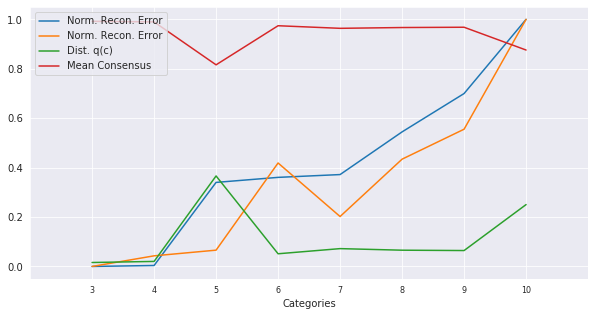

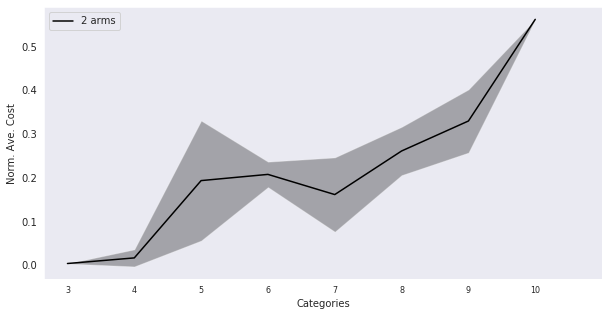

In [6]:
fig1, fig2 = K_selection(sum_dict, n_categories, n_arm)

In [27]:
model_order = 6
selected_model = glob.glob(saving_folder + '/model/cpl_mixVAE_model_after_pruning_' + str(n_categories - model_order) + '*')[0]
cpl_mixVAE, data, outcome = eval_mixmodel(n_categories=n_categories, 
                           state_dim=state_dim, 
                           n_arm=n_arm,
                           latent_dim=latent_dim,
                           fc_dim=fc_dim,
                           tau=tau,
                           subclass=subclass,
                           saving_folder=saving_folder, 
                           data_path=data_path,
                           device=device,
                           models=[selected_model])

loading AD L4-IT data ... 
Data is loaded
using CPU ...
/home/yeganeh/Remote-AI/cplmixVAE_AD/results/cpl_mixVAE/L4-IT_run_1_K_10_Sdim_10_ngene_4130_fcDim_100_latDim_30_lr_0.001_pDrop_0.2_n_arm_2_tau_0.1_bsize_1000_nepoch_1000_nepochP_1000/model/cpl_mixVAE_model_after_pruning_4_2022-08-25-22-51-14.pth
/home/yeganeh/Remote-AI/cplmixVAE_AD/results/cpl_mixVAE/L4-IT_run_1_K_10_Sdim_10_ngene_4130_fcDim_100_latDim_30_lr_0.001_pDrop_0.2_n_arm_2_tau_0.1_bsize_1000_nepoch_1000_nepochP_1000/model/model_eval


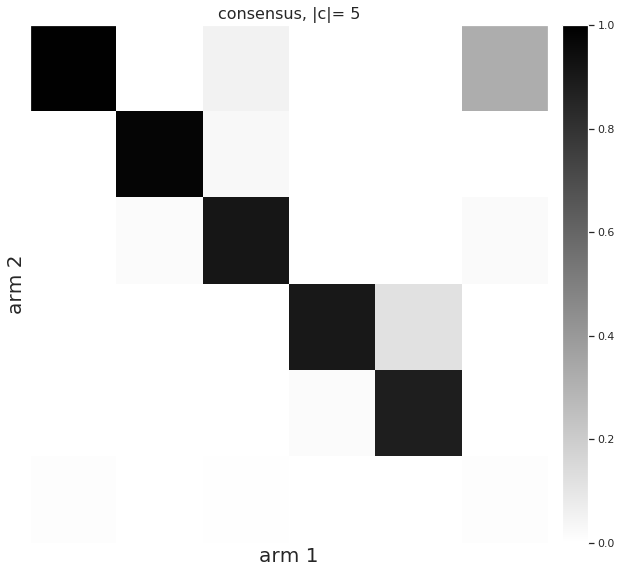

In [28]:
plt.figure(figsize=[10,10])
ax = plt.gca()
cons = np.diag(outcome['consensus'][0])
selected_cat = np.where(cons > .8)[0]
im = ax.imshow(outcome['consensus'][0], cmap='binary', vmax=1)
plt.xlabel('arm 1', fontsize=20)
plt.ylabel('arm 2', fontsize=20)
plt.xticks([])
plt.yticks([])
plt.title('consensus, |c|= ' + str(sum(cons > .8)), fontsize=16)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
plt.colorbar(im, cax=cax)
# model_order = sum(cons > .8)

[1 0 4 5 2 3]
[1 0 4 5 2 3]


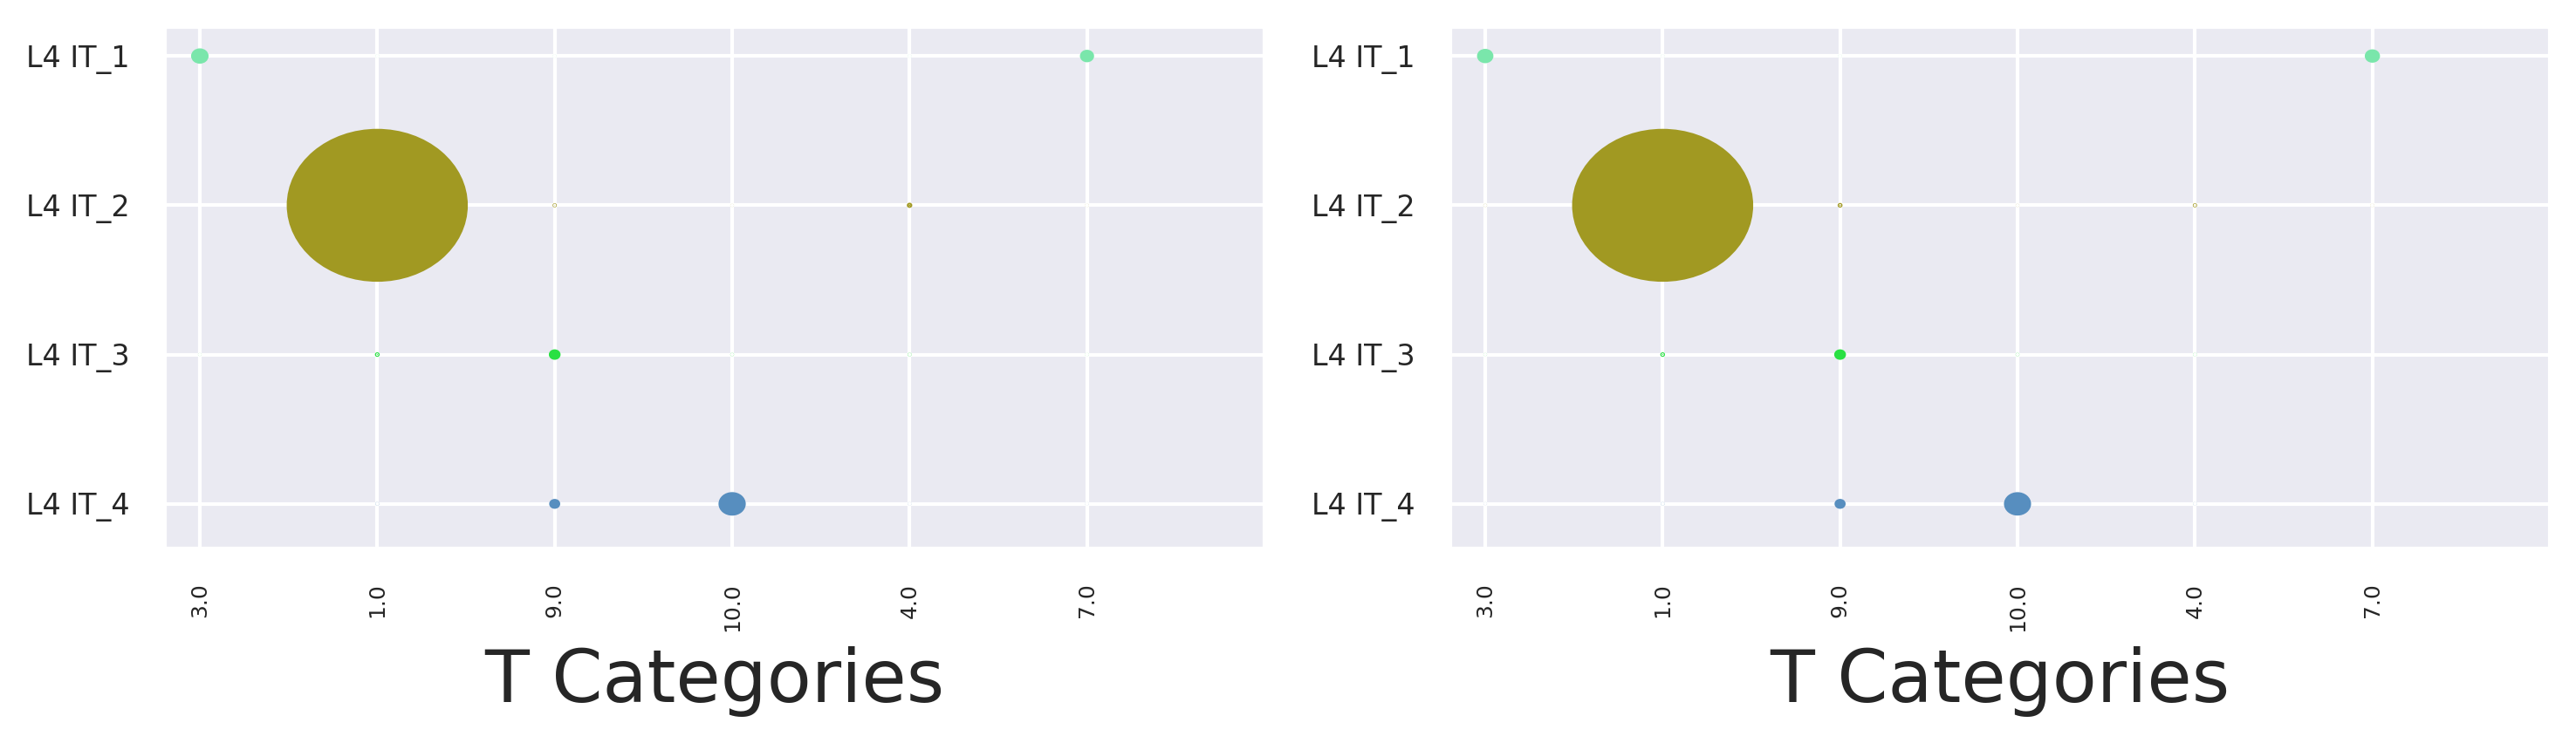

In [29]:
data['supertype_scANVI'] = np.array(data['supertype_scANVI'])
T_class = np.unique(data['supertype_scANVI'])
color = ['#7AE6AB', '#A19922', '#29E043', '#578EBF']
data['color'] = np.copy(data['cluster_color'])
data['label_id'] = np.copy(data['scvi_labels'])
uniq_clr = []
for i_type, ttype in enumerate(T_class):
    idx = np.where(data['supertype_scANVI'] == ttype)[0]
    data['label_id'][idx] = i_type + 1
    data['color'][idx] = color[i_type]
    uniq_clr.append(color[i_type])

cT_vs_cT = outcome['cT_vs_cT'][0]
confm = np.zeros((n_arm, len(T_class), model_order))
fig, axs = plt.subplots(1, n_arm, figsize=(10, 3), dpi=300)
for arm in range(n_arm): 
    categories = np.unique(outcome['pred_label'][-1][arm])
    perform_mat = cT_vs_cT[arm, :, :]
    row_sum = perform_mat.sum(axis=1)
    confm[arm, :, :] = np.divide(perform_mat, row_sum[:, np.newaxis], 
                        out=np.zeros_like(perform_mat), 
                        where=row_sum[:, np.newaxis]!=0)
    row_ind, col_ind = linear_sum_assignment(1 - perform_mat)

    if model_order > len(T_class):
        not_used_cat = [a for a in range(model_order) if a not in list(col_ind)]
        cat_indx = np.concatenate((col_ind, np.array(not_used_cat)))
    else:
        cat_indx = col_ind
    print(cat_indx)


    mtx = perform_mat[:, cat_indx] / np.max(perform_mat[:, cat_indx]) / 2
    for l in range(len(T_class)):
        for col in range(model_order):
            xy = np.array([col, l])
            axs[arm].add_patch(plt.Circle(xy, radius=(mtx[l, col]), color=color[l]))
    axs[arm].set_xlim([-.2, model_order])
    axs[arm].set_ylim([-.2, len(T_class)-.7])
    axs[arm].invert_yaxis()
    axs[arm].set_yticks(np.arange(len(T_class)))
    axs[arm].set_xticks(np.arange(model_order))
    axs[arm].set_yticklabels(T_class, fontsize=8)
    axs[arm].set_xticklabels(categories[cat_indx], fontsize=6, rotation=90)
    axs[arm].set_xlabel('T Categories', fontsize=20)

fig.tight_layout()

In [10]:
perform_mat.shape

(4, 7)

/home/yeganeh/miniconda3/envs/tf14-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


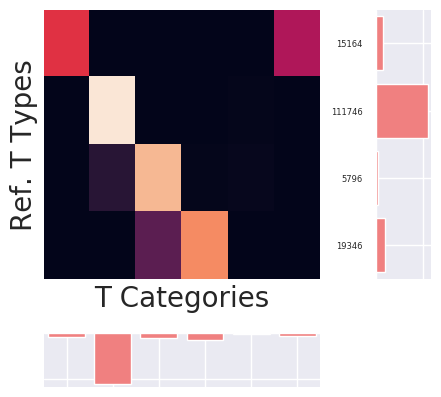

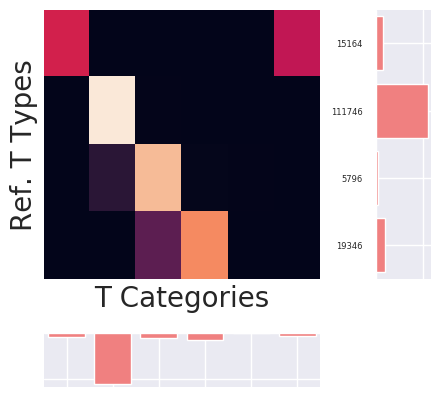

In [30]:
for arm in range(n_arm):
    fig = plt.figure(figsize=(5, 5), dpi=100)
    grid = plt.GridSpec(4, 4, hspace=1, wspace=1)
    ax_main = fig.add_subplot(grid[:-1, :-1])
    ax_right = fig.add_subplot(grid[:-1, -1], xticklabels=[])
    ax_bottom = fig.add_subplot(grid[-1, 0:-1], xticklabels=[], yticklabels=[])
    sns.set(font_scale=1.)
    sns.heatmap(np.squeeze(confm[arm, :, cat_indx].T), vmin=0, xticklabels=[], yticklabels=[], vmax=1, ax=ax_main, cbar=False)
    ax_main.set_ylabel('Ref. T Types', fontsize=20)
    ax_main.set_xlabel('T Categories', fontsize=20)
    ax_main.set_yticklabels(ax_main.get_yticklabels())

    # histogram on the right
    perform_mat = cT_vs_cT[arm, :, :]
    ax_bottom.bar(np.arange(model_order), np.sum(perform_mat[:, cat_indx], axis=0), color='lightcoral')
    # ax_bottom.set_ylim([0, 300])
    ax_bottom.invert_yaxis()
    ax_bottom.set_xlim([-.5, model_order-.5])
    ax_bottom.spines['top'].set_visible(False)
    ax_bottom.spines['right'].set_visible(False)
    ax_bottom.spines['bottom'].set_visible(False)
    ax_bottom.spines['left'].set_visible(False)

    # histogram in the bottom
    ax_right.barh(np.arange(len(T_class)), np.sum(perform_mat[:, cat_indx], axis=1).T, color='lightcoral')
    ax_right.set_ylim([-.5, len(T_class)-.5])
    # ax_right.set_xlim([0, 300])
    ax_right.set_yticks(np.arange(len(T_class)))
    ax_right.invert_yaxis()
    ax_right.set_yticklabels(np.sum(perform_mat[:, cat_indx], axis=1).astype(int), fontsize=6)
    ax_right.spines['top'].set_visible(False)
    ax_right.spines['right'].set_visible(False)
    ax_right.spines['bottom'].set_visible(False)
    ax_right.spines['left'].set_visible(False)

    fig.tight_layout()
    plt.savefig(saving_folder + '/confmax_K_' + str(model_order) + '_arm_' + str(arm) + '.png', dpi=600)


1.0
using CPU ...
Total loss: 0.030480513482221534
Total loss: 0.0342892875695335
Total loss: 0.03201434451122103
Total loss: 0.030900441278520572
Total loss: 0.015893421497561837
Total loss: 0.03111392498249188
Total loss: 0.014141148814815097
Total loss: 0.03391944168418247
Total loss: 0.030218848655100113
Total loss: 0.031122066949527443


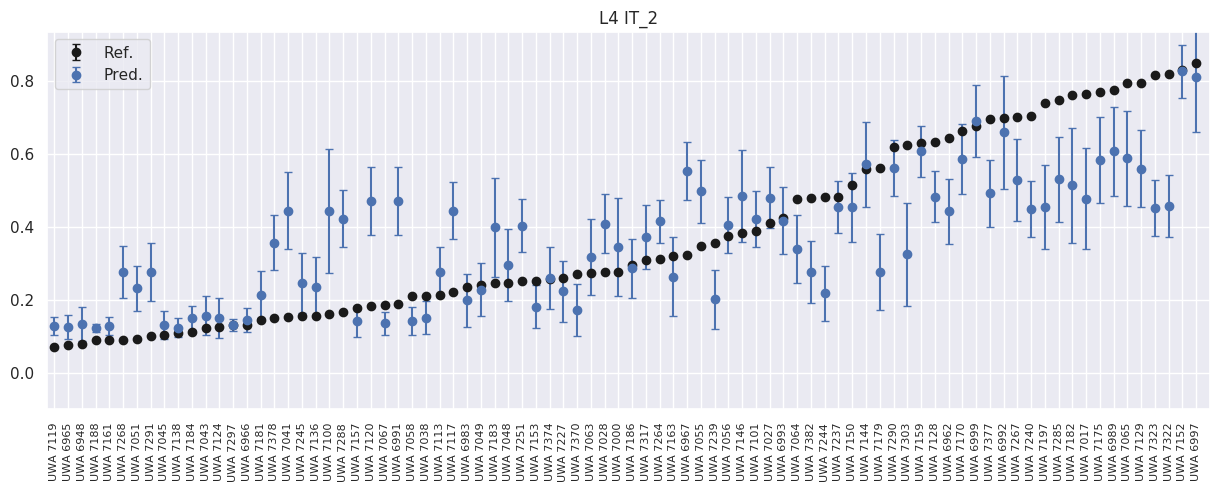

Pearsons correlation: 0.775
3.0
using CPU ...
Total loss: 0.02783605344593525
Total loss: 0.02759738899767399
Total loss: 0.02580941393971443
Total loss: 0.024915018677711488
Total loss: 0.030521155521273612
Total loss: 0.027908452600240708
Total loss: 0.026376691460609437
Total loss: 0.02494011726230383
Total loss: 0.023570986464619637
Total loss: 0.027695926278829573


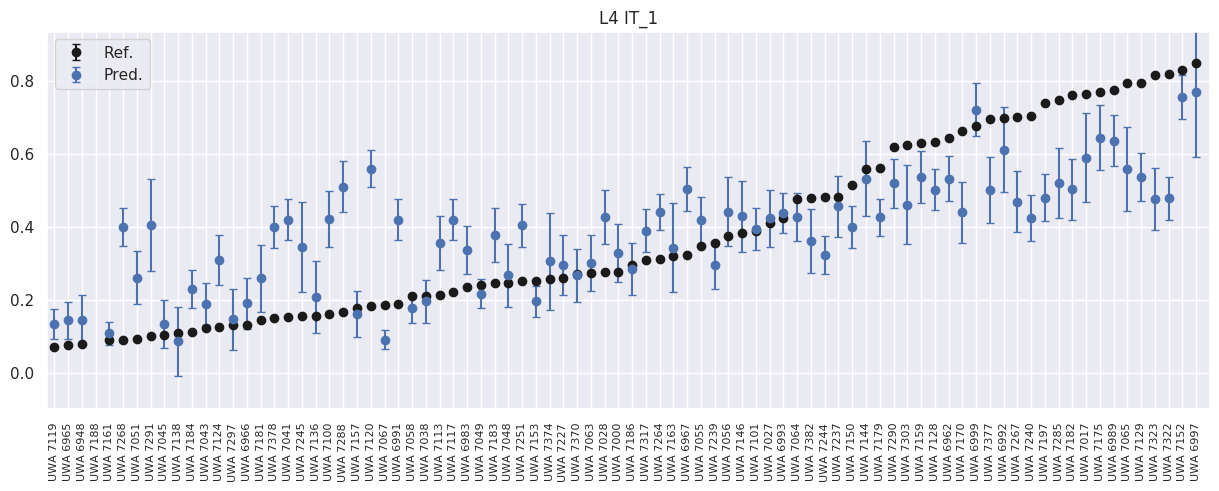

Pearsons correlation: 0.991
4.0
using CPU ...
7.0
using CPU ...
Total loss: 0.027785631828010082
Total loss: 0.02439258061349392
Total loss: 0.02565939724445343
Total loss: 0.023756837705150247
Total loss: 0.023865692783147097
Total loss: 0.025796455331146717
Total loss: 0.02823215164244175
Total loss: 0.023768160957843065
Total loss: 0.030426491983234882
Total loss: 0.03151972917839885


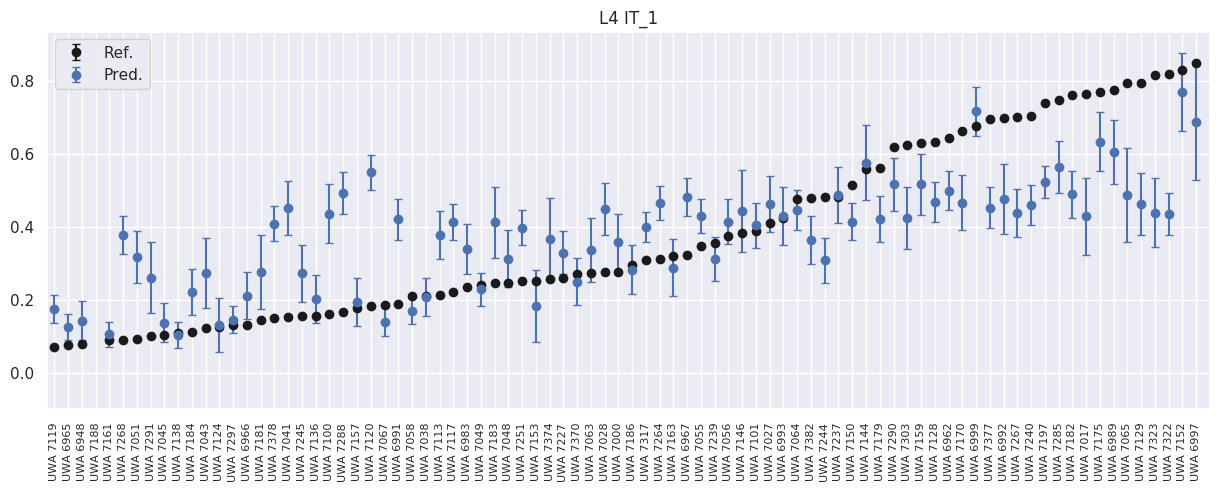

Pearsons correlation: 0.989
9.0
using CPU ...
Total loss: 0.026604894548654556
Total loss: 0.026385660593708355
Total loss: 0.030122033630808193
Total loss: 0.025362620130181313
Total loss: 0.025606727227568626
Total loss: 0.026736848056316376
Total loss: 0.02645860364039739
Total loss: 0.03095453977584839
Total loss: 0.025054200862844784
Total loss: 0.0270206518471241


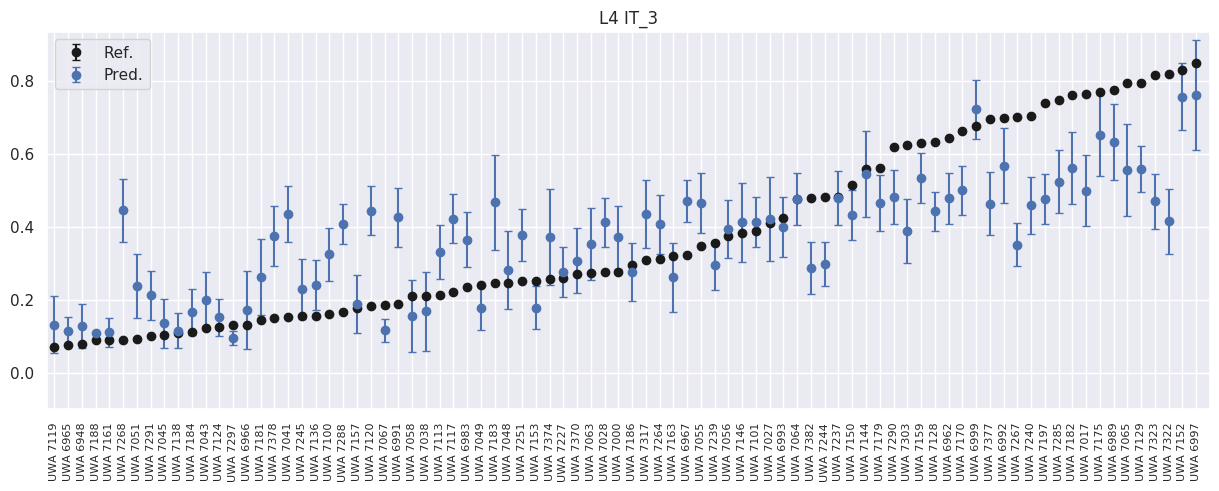

Pearsons correlation: 0.789
10.0
using CPU ...
Total loss: 0.02170734474202618
Total loss: 0.025793994893319905
Total loss: 0.02226895617786795
Total loss: 0.02455344086047262
Total loss: 0.02448543778154999
Total loss: 0.025534322136081755
Total loss: 0.021793439402244985
Total loss: 0.02604038396384567
Total loss: 0.02397496218327433
Total loss: 0.02498471550643444


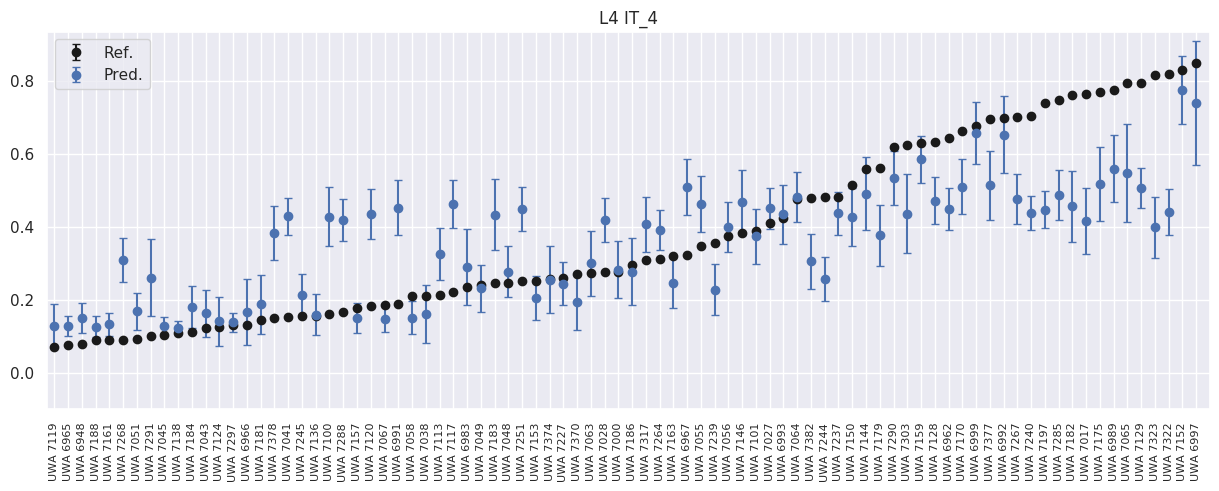

Pearsons correlation: 0.773


In [32]:
from utils.state_analysis import state_analyzer
from sklearn.model_selection import KFold
from scipy.stats import pearsonr

folder_name = f'{subclass}_run_{n_run}_K_{n_categories}_Sdim_{state_dim}_ngene_{n_gene}_fcDim_{fc_dim}_latDim_{latent_dim}_lr_{lr}_pDrop_{p_drop}_n_arm_{n_arm}_tau_{tau}_bsize_{batch_size}_nepoch_{n_epoch}_nepochP_{n_epoch_p}'
saving_folder = path + "/results/cpl_mixVAE/"
saving_folder = saving_folder + str(folder_name)

arm = 0
seed = 100
kfold = 10
state = outcome['state_mu'][arm, :, :]
pred_type = outcome['pred_label'][-1][arm, :]
s_idx = outcome['sample_id'][-1].astype(int)
cat = np.unique(pred_type)
metadata = 'ps_time'
    

uniq_score = np.unique(data[metadata])
uniq_donor = np.array([data['external_donor_name'][data[metadata]==u_m][0] for u_m in uniq_score])

for i_c, c in enumerate(cat):
    print(c)
    eval_dict = []
    error = []
    meta_true = []
    meta_pred = []
    donors_list = []
    idx = np.where(pred_type == c)[0]
    ref_t = data['supertype_scANVI'][s_idx[idx]]
    uniq_ref_t = np.unique(ref_t)
    meta_y = data[metadata][s_idx[idx]]
    tmp_donors = data['external_donor_name'][s_idx[idx]]
    n_types = [sum(ref_t==tt) for tt in uniq_ref_t]
    idxx = np.where(ref_t == uniq_ref_t[np.argmax(n_types)])[0]
    x = state[idx[idxx], :]
    y = 1. * meta_y[idxx]
    donors = tmp_donors[idxx]
    classifier = state_analyzer(saving_folder=saving_folder, device=device)
    kf = KFold(n_splits=kfold, random_state=seed, shuffle=True)
    m = 0
    for train_index, test_index in kf.split(x):
        m += 1
        classifier.init_model(input_dim=state_dim, output_dim=1, lr=0., std=0.1, c=int(c), binary=False)
        try:
            trained_model = glob.glob(saving_folder + '/model/deepClassifier_' + metadata + '_fold_' + str(m) + '_cat_' + str(int(c)) + '*')[0]
            classifier.load_model(trained_model)
            f = open(saving_folder + '/summary_' + metadata + '_fold_' + str(m) + '_cat_' + str(int(c))+ '.p', "rb")
            data_dict = pickle.load(f)
            f.close()
            indx = data_dict['sample_indx'].astype(int)
            donors_list.append(donors[indx])
            eval_dict.append(classifier.eval_prediction(x[indx, :], y[indx], donors[indx], 200))
            meta_true.append(eval_dict[-1]['metadata'])
            meta_pred.append(eval_dict[-1]['prediction'])
            error.append(np.mean(np.abs(eval_dict[-1]['metadata'] - eval_dict[-1]['prediction'])))
        except:
            break

    if m > 1:
        meta_true = np.concatenate(meta_true)
        meta_pred = np.concatenate(meta_pred)
        donors_list = np.concatenate(donors_list)

        meta_true_mean, meta_true_std = [], []
        meta_pred_mean, meta_pred_std = [], []

        for i_d, dd in enumerate(uniq_donor):
            d_idx = np.where(donors_list==dd)[0]
            if len(d_idx) > 0:
                meta_true_mean.append(np.median(meta_true[d_idx]))
                meta_true_std.append(np.std(meta_true[d_idx]))
                meta_pred_mean.append(np.median(meta_pred[d_idx]))
                meta_pred_std.append(np.std(meta_pred[d_idx]))
            else:
                meta_true_mean.append(-10)
                meta_true_std.append(0)
                meta_pred_mean.append(-10)
                meta_pred_std.append(0)

        meta_true_mean = np.array(meta_true_mean)
        meta_true_std = np.array(meta_true_std)
        meta_pred_mean = np.array(meta_pred_mean)
        meta_pred_std = np.array(meta_pred_std)

        x = np.arange(len(uniq_donor))
        plt.figure(figsize=[15, 5],dpi=100)
        plt.errorbar(x, meta_true_mean,  yerr = meta_true_std, linestyle='None',  fmt='ok',  capsize=3,  ecolor='k', label='Ref.')
        # plt.plot(x, y0, '--', color='black')
        plt.errorbar(x, meta_pred_mean,  yerr = meta_pred_std, linestyle='None',  fmt='ob',  capsize=3,  ecolor='b', label='Pred.')
        # plt.plot(x, y1, '-', color='blue')
        plt.xticks(x, uniq_donor, rotation=90, fontsize=8)
        plt.xlim([-.5, np.max(x)+1])
        plt.ylim([-0.1, np.max(y)+0.1*np.max(y)])
        plt.legend()
        plt.title(uniq_ref_t[np.argmax(n_types)])
        plt.show()

        corr, _ = pearsonr(meta_true_mean, meta_pred_mean)
        print('Pearsons correlation: %.3f' % corr)


1.0
using CPU ...
Total loss: 0.016202376039083383
Total loss: 0.016388535892474465
Total loss: 0.035102010380277146
Total loss: 0.034252097306307405
Total loss: 0.034745568563396646
Total loss: 0.03688980619023953
Total loss: 0.034351580672331954
Total loss: 0.03646515975872587
Total loss: 0.03549759392210815
Total loss: 0.03476115491191324


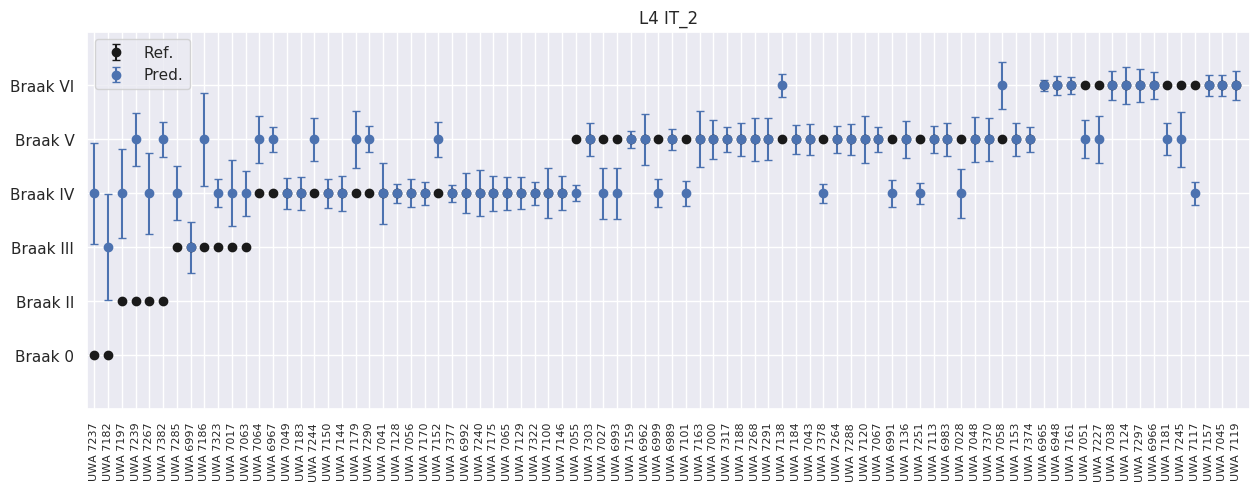

Pearsons correlation: 0.702
3.0
using CPU ...
Total loss: 0.027005285769701005
Total loss: 0.035579242184758185
Total loss: 0.03460712656378746
Total loss: 0.03152579627931118
Total loss: 0.031880568340420724
Total loss: 0.029632481187582015
Total loss: 0.027491926774382593
Total loss: 0.031536861509084704
Total loss: 0.0321217454969883
Total loss: 0.029437529668211938


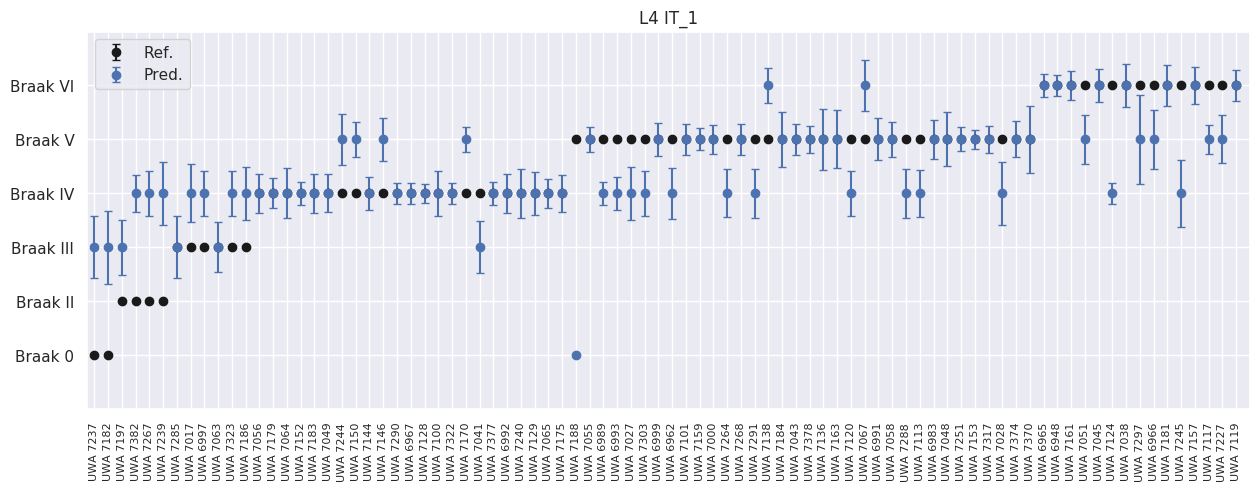

Pearsons correlation: 0.038
4.0
using CPU ...
7.0
using CPU ...
Total loss: 0.03453168459236622
Total loss: 0.03195361699908972
Total loss: 0.02660476928576827
Total loss: 0.033918571658432484
Total loss: 0.03470962168648839
Total loss: 0.0294693810865283
Total loss: 0.033950839191675186
Total loss: 0.03068753657862544
Total loss: 0.027700345497578382
Total loss: 0.031739022582769394


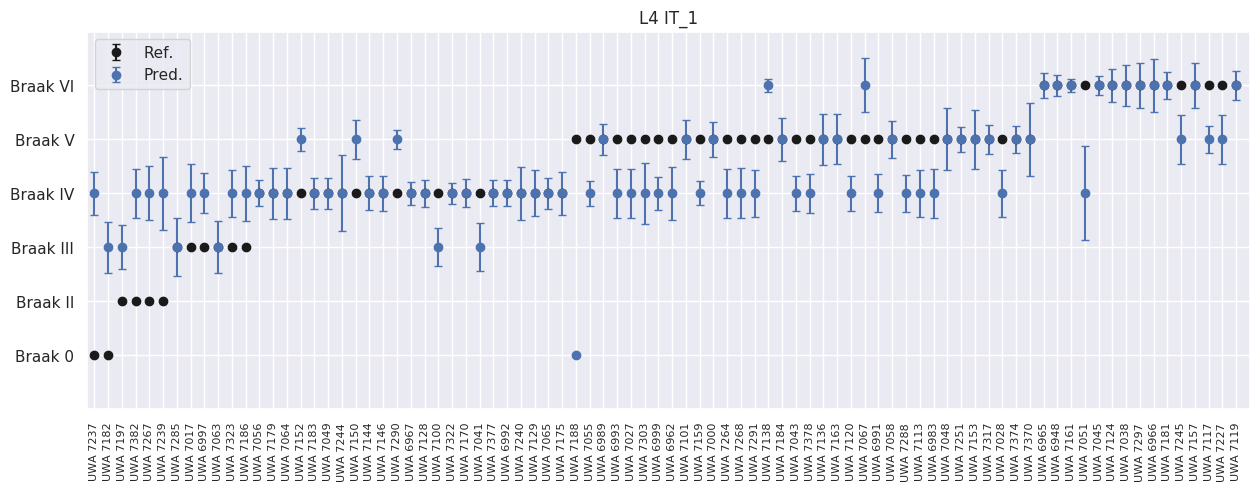

Pearsons correlation: 0.043
9.0
using CPU ...
Total loss: 0.0372160275777181
Total loss: 0.02861631102859974
Total loss: 0.02994536856810252
Total loss: 0.02829759692152341
Total loss: 0.033828401317199074
Total loss: 0.03131567935148875
Total loss: 0.03257292198638121
Total loss: 0.02942277987798055
Total loss: 0.027854064479470253
Total loss: 0.030940058330694836


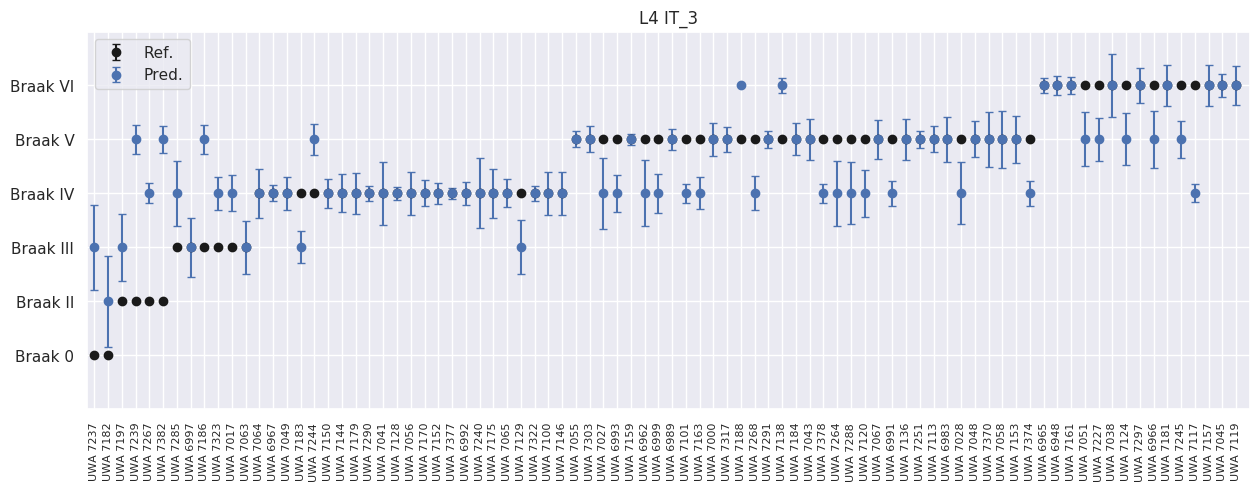

Pearsons correlation: 0.725
10.0
using CPU ...
Total loss: 0.027147524757310748
Total loss: 0.022899583564139903
Total loss: 0.023256437270902097
Total loss: 0.02666447521187365
Total loss: 0.026938708731904626
Total loss: 0.030785755603574216
Total loss: 0.02577331685461104
Total loss: 0.02551719336770475
Total loss: 0.025175986345857382
Total loss: 0.026008041691966355


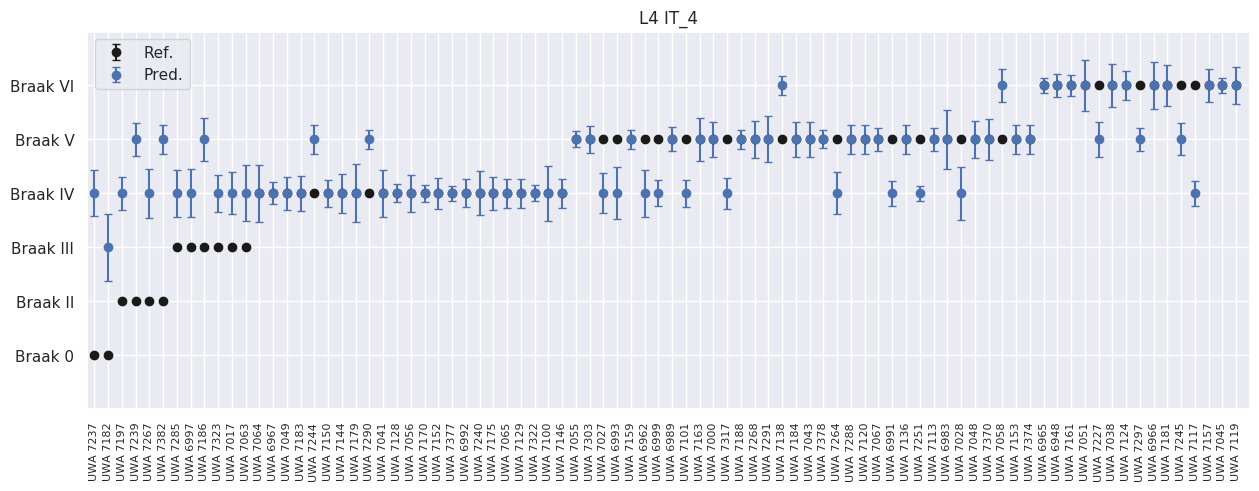

Pearsons correlation: 0.700


In [34]:
from utils.state_analysis import state_analyzer
from sklearn.model_selection import KFold

folder_name = f'{subclass}_run_{n_run}_K_{n_categories}_Sdim_{state_dim}_ngene_{n_gene}_fcDim_{fc_dim}_latDim_{latent_dim}_lr_{lr}_pDrop_{p_drop}_n_arm_{n_arm}_tau_{tau}_bsize_{batch_size}_nepoch_{n_epoch}_nepochP_{n_epoch_p}'
saving_folder = path + "/results/cpl_mixVAE/"
saving_folder = saving_folder + str(folder_name)

arm = 0
seed = 100
kfold = 10
state = outcome['state_mu'][arm, :, :]
pred_type = outcome['pred_label'][-1][arm, :]
s_idx = outcome['sample_id'][-1].astype(int)
cat = np.unique(pred_type)
metadata = 'braak'
m_ind = []

if metadata == 'braak':
    data['braak_num'] = np.zeros(len(data[metadata]))
    data['braak_int'] = np.zeros(len(data[metadata]))
    indx_0 = np.where(data[metadata] == 'Braak 0')[0]
    indx_ii = np.where(data[metadata] == 'Braak II')[0]
    indx_iii = np.where(data[metadata] == 'Braak III')[0]
    indx_iv = np.where(data[metadata] == 'Braak IV')[0]
    indx_v = np.where(data[metadata] == 'Braak V')[0]
    indx_vi = np.where(data[metadata] == 'Braak VI')[0]
    data['braak_num'][indx_0] = 0.
    data['braak_num'][indx_ii] = 0.2
    data['braak_num'][indx_iii] = 0.4
    data['braak_num'][indx_iv] = 0.6
    data['braak_num'][indx_v] = 0.8
    data['braak_num'][indx_vi] = 1.
    data['braak_int'][indx_0] = 0
    data['braak_int'][indx_ii] = 2
    data['braak_int'][indx_iii] = 3
    data['braak_int'][indx_iv] = 4
    data['braak_int'][indx_v] = 5
    data['braak_int'][indx_vi] = 6
    metadata = 'braak_num'

for i_c, c in enumerate(cat):
    print(c)
    eval_dict = []
    error = []
    meta_true = []
    meta_pred = []
    donors_list = []
    idx = np.where(pred_type == c)[0]
    ref_t = data['supertype_scANVI'][s_idx[idx]]
    uniq_ref_t = np.unique(ref_t)
    meta_y = data[metadata][s_idx[idx]]
    tmp_donors = data['external_donor_name'][s_idx[idx]]
    n_types = [sum(ref_t==tt) for tt in uniq_ref_t]
    idxx = np.where(ref_t == uniq_ref_t[np.argmax(n_types)])[0]
    x = state[idx[idxx], :]
    y = 1. * meta_y[idxx]
    donors = tmp_donors[idxx]
    classifier = state_analyzer(saving_folder=saving_folder, device=device)
    kf = KFold(n_splits=kfold, random_state=seed, shuffle=True)
    m = 0
    for train_index, test_index in kf.split(x):
        m += 1
        classifier.init_model(input_dim=state_dim, output_dim=1, lr=0., std=0.1, c=int(c), binary=False)
        try:
            trained_model = glob.glob(saving_folder + '/model/deepClassifier_' + metadata + '_fold_' + str(m) + '_cat_' + str(int(c)) + '*')[0]
            classifier.load_model(trained_model)
            f = open(saving_folder + '/summary_' + metadata + '_fold_' + str(m) + '_cat_' + str(int(c))+ '.p', "rb")
            data_dict = pickle.load(f)
            f.close()
            indx = data_dict['sample_indx'].astype(int)
            donors_list.append(donors[indx])
            eval_dict.append(classifier.eval_prediction(x[indx, :], y[indx], donors[indx], 200))
            meta_true.append(eval_dict[-1]['metadata'])
            meta_pred.append(eval_dict[-1]['prediction'])
            error.append(np.mean(np.abs(eval_dict[-1]['metadata'] - eval_dict[-1]['prediction'])))
        except:
            break

    if m > 1:
        meta_true = np.concatenate(meta_true)
        meta_pred = np.concatenate(meta_pred)
        donors_list = np.concatenate(donors_list)


        meta_true_mean, meta_true_std = [], []
        meta_pred_mean, meta_pred_std = [], []

        for i_d, dd in enumerate(uniq_donor):
            d_idx = np.where(donors_list==dd)[0]
            if len(d_idx) > 0:
                meta_true_mean.append(np.median(meta_true[d_idx]))
                meta_true_std.append(np.std(meta_true[d_idx]))
                meta_pred_mean.append(np.median(meta_pred[d_idx]))
                meta_pred_std.append(np.std(meta_pred[d_idx]))
            else:
                tmp = data[metadata][np.where(data['external_donor_name']==dd)[0]][0]
                meta_true_mean.append(tmp)
                meta_true_std.append(0)
                meta_pred_mean.append(-10)
                meta_pred_std.append(0)
                

        meta_true_mean = np.array(meta_true_mean)
        meta_true_std = np.array(meta_true_std)
        meta_pred_mean = np.array(meta_pred_mean)
        meta_pred_std = np.array(meta_pred_std)

        values = np.unique(meta_true_mean)
        meta_pred_score = []
        for p_m in meta_pred_mean:
            dist = (p_m - values)**2
            meta_pred_score.append(values[np.argmin(dist)])

        meta_pred_score = np.array(meta_pred_score)
        m_indx = np.argsort(meta_true_mean)
        x = np.arange(len(uniq_donor))
        plt.figure(figsize=[15, 5],dpi=100)
        plt.errorbar(x, meta_true_mean[m_indx],  yerr = meta_true_std[m_indx], linestyle='None',  fmt='ok',  capsize=3,  ecolor='k', label='Ref.')
        plt.errorbar(x, meta_pred_score[m_indx],  yerr = meta_pred_std[m_indx], linestyle='None',  fmt='ob',  capsize=3,  ecolor='b', label='Pred.')
        plt.yticks(np.unique(data[metadata]), np.unique(data['braak']))
        plt.xticks(x, uniq_donor[m_indx], rotation=90, fontsize=8)
        plt.xlim([-.5, np.max(x)+1])
        plt.ylim([-.2, 1.2])
        plt.legend()
        plt.title(uniq_ref_t[np.argmax(n_types)])
        plt.show()

        corr, _ = pearsonr(meta_true_mean, meta_pred_mean)
        print('Pearsons correlation: %.3f' % corr)